**Importiere die notwendigen Packages**

In [2]:
# Empfehlung für Colab: Installiere alles was Du brauchst
# %pip install pandas pivottablejs numpy altair matplotlib geopandas folium

In [3]:
import pandas as pd
import pivottablejs
from pivottablejs import pivot_ui
import numpy as np
import altair as alt
import matplotlib.pyplot as plt
from datetime import datetime
import geopandas as gpd
import folium 



Definiere Settings. Hier das Zahlenformat von Float-Werten (z.B. *'{:,.2f}'.format* mit Komma als Tausenderzeichen), 

In [4]:
pd.options.display.float_format = '{:.0f}'.format
pd.set_option('display.width', 100)
pd.set_option('display.max_columns', 15)

Importiere einen Datensatz von der **DWH_INT** Dropzone.

- Beachte dabei die Notation des Pfades...
- Definiere mal aktuell noch keine weiteren Parameter beim Import

**Dataset auf INTEG Datenkatalog**: https://data.integ.stadt-zuerich.ch/dataset/int_dwh_bau_best_whg_energietraegerart_statzone_seit2017_od5331

(int_dwh)

In [39]:
# Filepath
fp = r"//szh.loc/ssz/applikationen/OGD_Dropzone/INT_DWH/bau_best_whg_energietraegerart_statzone_seit2017_od5331/BAU533OD5331.csv"
#\\szh.loc\ssz\applikationen\OGD_Dropzone\INT_DWH\bau_best_whg_zizahl_wfl_bauperi_ea_quartier_jahr_OD5081\BAU508OD5081.csv

# Read the data
data2betested = pd.read_csv(
    fp, 
    sep=',',
   #usecols=[0,1,2,3,4,6],
   #names=['stationid','year','month','avgtemp','latitude','longitude','elevation','station','countryid','country'],
   #skiprows=1,
   # parse_dates=[0],
    parse_dates=True,
    #date_parser=lambda x: pd.to_datetime(x, format="%Y"), 
    #index_col="date_time",
    low_memory=False    
    )

In der Folge ein paar erste Tests:

In [40]:
type(data2betested)

pandas.core.frame.DataFrame

 - 1) Zeige eine kurze Vorschau der importierten Daten
 - 2) Weise die Datentypen aus
 - 3) Zeige die Shape (Umfang) des Datensatzes an

In [41]:
data2betested.head(3)

,Jahr,StatZoneSort,StatZoneLang,QuarSort,QuarLang,KreisSort,KreisLang,Bauperiode,Heizöl,Gas,Holz,Wärmepumpe,Fernwärme,Andere
0,2017,1,Zähringerstrasse,11,Rathaus,1,Kreis 1,1931-1950,0,1,0,0,0,0
1,2017,1,Zähringerstrasse,11,Rathaus,1,Kreis 1,1951-1970,11,6,0,0,0,0
2,2017,1,Zähringerstrasse,11,Rathaus,1,Kreis 1,1971-1980,0,17,0,0,0,0


In [42]:
data2betested.dtypes

Jahr             int64
StatZoneSort     int64
StatZoneLang    object
QuarSort         int64
QuarLang        object
KreisSort        int64
KreisLang       object
Bauperiode      object
Heizöl           int64
Gas              int64
Holz             int64
Wärmepumpe       int64
Fernwärme        int64
Andere           int64
dtype: object

In [43]:
data2betested.shape

(8322, 14)

Beschreibe einzelne Attribute

In [44]:
data2betested.describe()

,Jahr,StatZoneSort,QuarSort,KreisSort,Heizöl,Gas,Holz,Wärmepumpe,Fernwärme,Andere
count,8322,8322,8322,8322,8322,8322,8322,8322,8322,8322
mean,2019,110,69,7,33,67,1,11,23,0
std,1,62,34,3,73,140,17,45,82,5
min,2017,1,11,1,0,0,0,0,0,0
25%,2018,57,34,3,0,0,0,0,0,0
50%,2019,110,72,7,1,13,0,0,0,0
75%,2020,163,101,10,34,68,0,5,0,0
max,2021,216,123,12,1123,1433,513,1118,1090,191


Wie viele Nullwerte gibt es im Datensatz?

In [45]:
data2betested.isnull().sum()

Jahr            0
StatZoneSort    0
StatZoneLang    0
QuarSort        0
QuarLang        0
KreisSort       0
KreisLang       0
Bauperiode      0
Heizöl          0
Gas             0
Holz            0
Wärmepumpe      0
Fernwärme       0
Andere          0
dtype: int64

In gewissen Datensätzen kommen noch die Zeilen `Jahr` anstatt `StichDatJahr` vor. Diese werden hier für solche Fälle ergänzt.

In [46]:
if set(['Jahr']).issubset(data2betested.columns):
    data2betested['StichtagDatJahr'] = data2betested['Jahr'] 



Wandle die Spalte Jahr von Int zu **Datetime** um. Dies wird in den meisten Grafiken so benötigt.

In [47]:
data2betested['StichtagDatJahr']=pd.to_datetime(data2betested['StichtagDatJahr'], format='%Y')
#data2betested['Jahr']=pd.to_datetime(data2betested['Jahr'], format='%Y')
#data2betested['Jahr']=pd.to_datetime(data2betested['Jahr'], format='%Y')
#TO DO --> setze das Datum auf den 31.12. der Jahres.
#test=data2betested[['StichtagDatJahr']].date().replace(month=12, day=31)

data2betested


,Jahr,StatZoneSort,StatZoneLang,QuarSort,QuarLang,KreisSort,KreisLang,Bauperiode,Heizöl,Gas,Holz,Wärmepumpe,Fernwärme,Andere,StichtagDatJahr
0,2017,1,Zähringerstrasse,11,Rathaus,1,Kreis 1,1931-1950,0,1,0,0,0,0,2017-01-01
1,2017,1,Zähringerstrasse,11,Rathaus,1,Kreis 1,1951-1970,11,6,0,0,0,0,2017-01-01
2,2017,1,Zähringerstrasse,11,Rathaus,1,Kreis 1,1971-1980,0,17,0,0,0,0,2017-01-01
3,2017,1,Zähringerstrasse,11,Rathaus,1,Kreis 1,1981-1990,0,1,0,0,0,0,2017-01-01
4,2017,1,Zähringerstrasse,11,Rathaus,1,Kreis 1,1991-2000,0,0,0,0,0,0,2017-01-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8317,2021,216,Probsteistrasse,123,Hirzenbach,12,Kreis 12,1981-1990,18,0,0,5,22,0,2021-01-01
8318,2021,216,Probsteistrasse,123,Hirzenbach,12,Kreis 12,1991-2000,0,0,0,0,53,0,2021-01-01
8319,2021,216,Probsteistrasse,123,Hirzenbach,12,Kreis 12,2001-2010,0,1,0,7,40,0,2021-01-01
8320,2021,216,Probsteistrasse,123,Hirzenbach,12,Kreis 12,Vor 1931,5,0,0,1,0,0,2021-01-01


Bereite die Daten für die Grafik unten vor

In [48]:
Jahre = data2betested.groupby("StichtagDatJahr")
len(Jahre)

5

In [49]:
for key, group in Jahre:
    print(key, len(group))

2017-01-01 00:00:00 1664
2018-01-01 00:00:00 1666
2019-01-01 00:00:00 1664
2020-01-01 00:00:00 1663
2021-01-01 00:00:00 1665


In [50]:
myJahr = "2021-01-01"
aktuellesJahr=Jahre.get_group(myJahr)   
aktuellesJahr.head(3)


,Jahr,StatZoneSort,StatZoneLang,QuarSort,QuarLang,KreisSort,KreisLang,Bauperiode,Heizöl,Gas,Holz,Wärmepumpe,Fernwärme,Andere,StichtagDatJahr
6657,2021,1,Zähringerstrasse,11,Rathaus,1,Kreis 1,1931-1950,0,1,0,0,0,0,2021-01-01
6658,2021,1,Zähringerstrasse,11,Rathaus,1,Kreis 1,1951-1970,11,6,0,0,0,0,2021-01-01
6659,2021,1,Zähringerstrasse,11,Rathaus,1,Kreis 1,1971-1980,0,17,0,0,0,0,2021-01-01


**Selektionen und Aggregationen**

Check this [Doku](https://www.shanelynn.ie/summarising-aggregation-and-grouping-data-in-python-pandas/)

In [52]:
#test = data2betested.groupby(['StichtagDatJahr', 'AlterV20Kurz'])[['AnzBestWir']].agg()

# produces Pandas Series
    #data2betested.groupby(['StichtagDatJahr', 'KonOGDSort'])['AnzBestWir'].sum()
# Produces Pandas DataFrame
    #data2betested.groupby(['StichtagDatJahr', 'KonOGDSort'])[['AnzBestWir']].sum()
    
test = data2betested.groupby(
   ['StichtagDatJahr', 'QuarSort', 'QuarLang', 'Bauperiode']
).agg(
    {
        'Heizöl':(sum),     # Sum --> (sum)
        'Gas': (sum),   
        'Holz': (sum),  
        'Wärmepumpe': (sum),
        'Fernwärme':(sum),
        'Andere': (sum)
    }
)
test.head(1000)


Heizöl   Gas  Holz  Wärmepumpe  Fernwärme  Andere
StichtagDatJahr QuarSort QuarLang  Bauperiode                                                   
2017-01-01      11       Rathaus   1931-1950        0    18     6           0          0       0
                                   1951-1970       47   206     0           0          0       0
                                   1971-1980        8    48     0           0          0       0
                                   1981-1990        0    18     0           0          0       0
                                   1991-2000        0     0     0           0          6       0
...                                               ...   ...   ...         ...        ...     ...
2020-01-01      82       Mühlebach 1981-1990       15   161     0           0          0       0
                                   1991-2000        0   208     0           9          0       0
                                   2001-2010        1    20     0          89          4       0
                                   Vor 1931       271  1221     0          41          0       1
                                   nach 2010        0    32    10         171          0       0

[1000 rows x 6 columns]

**Einfache Visualisierungen zur Plausi**

Exploriere die Daten mit Pivottable.JS

In [53]:
from pivottablejs import pivot_ui

pivot_ui(data2betested)

Liniendiagramm 
[Link zur Doku](https://altair-viz.github.io/gallery/multiline_highlight.html)

In [54]:
#mySelection = aktuellesJahr[(data2betested.QuarSort=31)]
mySelection = aktuellesJahr.groupby(['StichtagDatJahr', 'Bauperiode'])[['Heizöl','Gas','Fernwärme','Wärmepumpe', 'Andere']].sum()
mySelection.head(10)

Heizöl    Gas  Fernwärme  Wärmepumpe  Andere
StichtagDatJahr Bauperiode                                              
2021-01-01      1931-1950    10765  18573       4645        1617      17
                1951-1970    20256  20860       9422        1370       9
                1971-1980     6434   9460       2893         818      64
                1981-1990     1774   7623       1904         309      14
                1991-2000      480   5432       2208         243      25
                2001-2010      146   4845       5936        1787     196
                Vor 1931     11457  44004       2879        2073     238
                nach 2010       53   2538      10003       13852      74

In [55]:
mySelection = aktuellesJahr[["StichtagDatJahr","QuarLang", "KreisLang","Bauperiode","Wärmepumpe"]]
mySelection

,StichtagDatJahr,QuarLang,KreisLang,Bauperiode,Wärmepumpe
6657,2021-01-01,Rathaus,Kreis 1,1931-1950,0
6658,2021-01-01,Rathaus,Kreis 1,1951-1970,0
6659,2021-01-01,Rathaus,Kreis 1,1971-1980,0
6660,2021-01-01,Rathaus,Kreis 1,1981-1990,0
6661,2021-01-01,Rathaus,Kreis 1,1991-2000,0
...,...,...,...,...,...
8317,2021-01-01,Hirzenbach,Kreis 12,1981-1990,5
8318,2021-01-01,Hirzenbach,Kreis 12,1991-2000,0
8319,2021-01-01,Hirzenbach,Kreis 12,2001-2010,7
8320,2021-01-01,Hirzenbach,Kreis 12,Vor 1931,1


In [56]:
agg_mySelection = mySelection.groupby(
   ['StichtagDatJahr', 'KreisLang']
).agg(
    {
         #'Bauperiode"':(sum,min, max),     # Sum --> (sum)
         'Wärmepumpe': (sum, min, max)
    }
)
agg_mySelection

Wärmepumpe          
                                 sum min   max
StichtagDatJahr KreisLang                     
2021-01-01      Kreis 1           48   0    12
                Kreis 10        2344   0   282
                Kreis 11        3074   0   399
                Kreis 12         344   0    72
                Kreis 2         3622   0   692
                Kreis 3         1839   0   363
                Kreis 4          842   0   188
                Kreis 5          160   0   102
                Kreis 6         1375   0   146
                Kreis 7         2156   0   266
                Kreis 8         1000   0   133
                Kreis 9         5265   0  1118

In [57]:
mySelection = aktuellesJahr[(aktuellesJahr.KreisSort>10) & (aktuellesJahr.Wärmepumpe>0)]

mySelection.head()

,Jahr,StatZoneSort,StatZoneLang,QuarSort,QuarLang,KreisSort,KreisLang,Bauperiode,Heizöl,Gas,Holz,Wärmepumpe,Fernwärme,Andere,StichtagDatJahr
8029,2021,179,Mühlacker,111,Affoltern,11,Kreis 11,1931-1950,9,0,0,3,0,0,2021-01-01
8030,2021,179,Mühlacker,111,Affoltern,11,Kreis 11,1951-1970,6,17,0,1,0,0,2021-01-01
8032,2021,179,Mühlacker,111,Affoltern,11,Kreis 11,1981-1990,3,10,1,1,0,0,2021-01-01
8033,2021,179,Mühlacker,111,Affoltern,11,Kreis 11,1991-2000,0,47,0,2,0,0,2021-01-01
8034,2021,179,Mühlacker,111,Affoltern,11,Kreis 11,2001-2010,0,475,325,29,0,0,2021-01-01


In [58]:
# df_statzonen = df_statzonen[(df_statzonen.knr>0) & (df_statzonen.qname!="Hirslanden")]

highlight = alt.selection(type='single', on='mouseover',
                          fields=['QuarLang'], nearest=True)
#x='date:StichtagDatJahr',
base = alt.Chart(mySelection).encode(
    x='Bauperiode',
    y='Wärmepumpe',
    color='QuarLang'
)

points = base.mark_circle().encode(
    opacity=alt.value(0)
).add_selection(
    highlight
).properties(
    width=700 , height=300
)
lines = base.mark_line().encode(
    size=alt.condition(~highlight, alt.value(1.5), alt.value(4))
).interactive()

points + lines

alt.LayerChart(...)

In [59]:
alt.Chart(mySelection).mark_circle(size=60).encode(
    x='QuarLang',
    y='Bauperiode',
    #color='AnzWhg',
    #color=alt.Color('AnzNat', scale=alt.Scale(scheme='dark2')),
    color=alt.Color('Wärmepumpe', scale=alt.Scale(scheme='Reds')),
    tooltip=['QuarLang','StichtagDatJahr','Bauperiode','Wärmepumpe']
).interactive() # this makes the axes interactive: now you can zoom & pan




alt.Chart(...)

**Test: Choroplethenkarte**
Importiere die Geodaten als GeoJSON

In [60]:
# Read abt. Geopandas https://geopandas.org/docs/user_guide/io.html
# Wenn die Daten lokal agelegt sind, dann kannst Du folgendes machen:
##input_stadtquartiere = r"//szh.loc/ssz/data/GIS/Daten/Vektor/_aktuell/stzh.adm_statistische_quartiere_map.json"
##df_stadtquartiere = gpd.read_file(input_stadtquartiere)
##df_stadtquartiere.head(2)
#df_stadtkreise.dtypes

geojson_url = "https://www.ogd.stadt-zuerich.ch/wfs/geoportal/Statistische_Quartiere?service=WFS&version=1.1.0&request=GetFeature&outputFormat=GeoJSON&typename=adm_statistische_quartiere_map"
df_adm_statistische_quartiere_map = gpd.read_file(geojson_url)

df_adm_statistische_quartiere_map.head(5)


,id,kname,knr,objectid,objid,qname,qnr,geometry
0,adm_statistische_quartiere_map.1,Kreis 7,7,1,34,Hirslanden,73,"POLYGON ((8.55670 47.36406, 8.55682 47.36410, ..."
1,adm_statistische_quartiere_map.2,Kreis 8,8,2,33,Weinegg,83,"POLYGON ((8.55670 47.36405, 8.55672 47.36403, ..."
2,adm_statistische_quartiere_map.3,Kreis 8,8,3,32,Mühlebach,82,"POLYGON ((8.55423 47.36456, 8.55426 47.36452, ..."
3,adm_statistische_quartiere_map.4,Kreis 8,8,4,31,Seefeld,81,"POLYGON ((8.54795 47.36500, 8.54805 47.36489, ..."
4,adm_statistische_quartiere_map.7,Kreis 4,4,7,16,Werd,41,"POLYGON ((8.53300 47.37394, 8.53299 47.37392, ..."


Joine die importierten statistischen Daten des aktuellen Jahres zum Geodatensatz:

*Siehe dazu Doku zu [Geopandas](https://geopandas.org/docs/user_guide/mergingdata.html)*

In [61]:
aktuellesJahr.head()

,Jahr,StatZoneSort,StatZoneLang,QuarSort,QuarLang,KreisSort,KreisLang,Bauperiode,Heizöl,Gas,Holz,Wärmepumpe,Fernwärme,Andere,StichtagDatJahr
6657,2021,1,Zähringerstrasse,11,Rathaus,1,Kreis 1,1931-1950,0,1,0,0,0,0,2021-01-01
6658,2021,1,Zähringerstrasse,11,Rathaus,1,Kreis 1,1951-1970,11,6,0,0,0,0,2021-01-01
6659,2021,1,Zähringerstrasse,11,Rathaus,1,Kreis 1,1971-1980,0,17,0,0,0,0,2021-01-01
6660,2021,1,Zähringerstrasse,11,Rathaus,1,Kreis 1,1981-1990,0,1,0,0,0,0,2021-01-01
6661,2021,1,Zähringerstrasse,11,Rathaus,1,Kreis 1,1991-2000,0,0,0,0,0,0,2021-01-01


In [62]:
stats_agg_quartiere=aktuellesJahr.groupby(['StichtagDatJahr', 'QuarSort'])[['Wärmepumpe','Fernwärme','Gas', 'Heizöl','Andere']].sum()
#test = data2betested.groupby(['StichtagDatJahr', 'AlterV20Kurz'])[['AnzBestWir']].agg()
stats_agg_quartiere.head()
#test = data2betested.groupby(['StichtagDatJahr', 'AlterV20Kurz'])[['AnzBestWir']].agg()

Wärmepumpe  Fernwärme   Gas  Heizöl  Andere
StichtagDatJahr QuarSort                                             
2021-01-01      11                27          9  2101     161      29
                12                 7         85   193      48       4
                13                12          4   768      53      10
                14                 2          0   350      47       0
                21              2717        105  4781    2466      20

In [63]:
# Rename attribute stznr to StatZoneSort, so the IDs have the same name

stadtquartiere_shapes = df_adm_statistische_quartiere_map[['geometry', 'qnr', 'qname', 'knr']].rename(columns={'qnr': 'QuarSort'})

# Merge with `merge` method on shared variable (stznr und StatZoneSort):
stadtquartiere_shapes_joined = stadtquartiere_shapes.merge(stats_agg_quartiere, on='QuarSort')

stadtquartiere_shapes_joined.head(3)


,geometry,QuarSort,qname,knr,Wärmepumpe,Fernwärme,Gas,Heizöl,Andere
0,"POLYGON ((8.55670 47.36406, 8.55682 47.36410, ...",73,Hirslanden,7,317,15,2696,1014,11
1,"POLYGON ((8.55670 47.36405, 8.55672 47.36403, ...",83,Weinegg,8,286,0,1839,738,15
2,"POLYGON ((8.55423 47.36456, 8.55426 47.36452, ...",82,Mühlebach,8,384,14,2761,733,3


<AxesSubplot:>

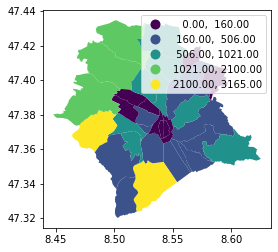

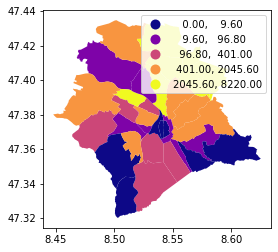

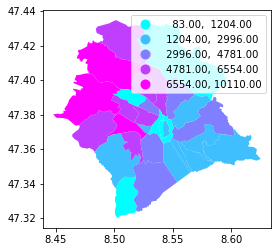

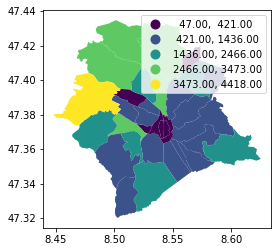

In [64]:
# Plot by StatQuartiere

stadtquartiere_shapes_joined.plot(column='Wärmepumpe', cmap='viridis', scheme='natural_breaks', legend=True )
#scheme werte: https://matplotlib.org/2.0.2/users/colormaps.html

stadtquartiere_shapes_joined.plot(column='Fernwärme', cmap='plasma', scheme='quantiles', legend=True )
#scheme werte: https://matplotlib.org/2.0.2/users/colormaps.html
stadtquartiere_shapes_joined.plot(column='Gas', cmap='cool', scheme='fisherjenks', legend=True )
#scheme werte: https://matplotlib.org/2.0.2/users/colormaps.html

stadtquartiere_shapes_joined.plot(column='Heizöl', cmap='viridis', scheme='natural_breaks', legend=True )
#scheme werte: https://matplotlib.org/2.0.2/users/colormaps.html

<AxesSubplot:>

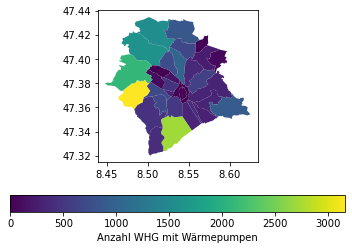

In [65]:
fig, ax = plt.subplots(1, 1)
stadtquartiere_shapes_joined.plot(column='Wärmepumpe', ax=ax, legend=True, legend_kwds={'label': "Anzahl WHG mit Wärmepumpen",'orientation': "horizontal"})


Noch zu prüfen, folgendes schöne Beispiel: https://docs.bokeh.org/en/latest/docs/user_guide/interaction/legends.html

Konkrete Beispiele von Bookeh in Jupyter NB: https://docs.bokeh.org/en/latest/docs/user_guide/jupyter.html

**Sharepoint als gecheckt markieren!**

Record auf Sharepoint: **[Link](http://kollaboration.intranet.stzh.ch/orga/ssz-produkte/Lists/SASA_Outputs/EditForm.aspx?ID=157&Source=%2Forga%2Fssz%2Dprodukte%2FLists%2FSASA%5FOutputs)**